# Libraries

In [1]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

# Functions

In [2]:
def detect_iqr_outliers(df, column, multiplier=1.5):
    """
    Detects outliers in a numeric column using the IQR method.
    Returns a boolean Series where True = outlier.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return (df[column] < lower_bound) | (df[column] > upper_bound)

# Import data

In [3]:
dfs = [pd.read_parquet(f) for f in glob.glob("../data/raw/*_eod.parquet")]
df = pd.concat(dfs, ignore_index=True)
df = df[['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'adj_close']]
df.head()

,date,symbol,open,high,low,close,volume,adj_close
0,2024-11-05T00:00:00+0000,META,567.30,573.48,566.67,572.43,9748300.0,572.43
1,2024-11-06T00:00:00+0000,META,562.75,573.00,555.17,572.05,18305400.0,572.05
2,2024-11-07T00:00:00+0000,META,576.89,594.80,575.21,591.70,14653700.0,591.70
3,2024-11-08T00:00:00+0000,META,591.54,593.10,584.52,589.34,9403300.0,589.34
4,2024-11-11T00:00:00+0000,META,586.36,587.00,576.51,583.17,10209100.0,583.17


# EDA

## First look

In [4]:
df.shape

(1736, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1736 entries, 0 to 1735
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1736 non-null   object 
 1   symbol     1736 non-null   object 
 2   open       1736 non-null   float64
 3   high       1736 non-null   float64
 4   low        1736 non-null   float64
 5   close      1736 non-null   float64
 6   volume     1736 non-null   float64
 7   adj_close  1736 non-null   float64
dtypes: float64(6), object(2)
memory usage: 108.6+ KB


> All columns are having the correct types.

In [6]:
df.symbol.nunique() # ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'TSLA']

7

> Correct 7 tickers

In [7]:
df.date = pd.to_datetime(df.date, utc=True)
df.date = df.date.dt.date # Remove time stamp since it's EOD data
df.head()

,date,symbol,open,high,low,close,volume,adj_close
0,2024-11-05,META,567.30,573.48,566.67,572.43,9748300.0,572.43
1,2024-11-06,META,562.75,573.00,555.17,572.05,18305400.0,572.05
2,2024-11-07,META,576.89,594.80,575.21,591.70,14653700.0,591.70
3,2024-11-08,META,591.54,593.10,584.52,589.34,9403300.0,589.34
4,2024-11-11,META,586.36,587.00,576.51,583.17,10209100.0,583.17


In [8]:
df.close.equals(df.adj_close)

False

## Null / Duplicate

In [9]:
df.isnull().sum()

date         0
symbol       0
open         0
high         0
low          0
close        0
volume       0
adj_close    0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

> There's no nulls or duplicates

## Numerical distribution

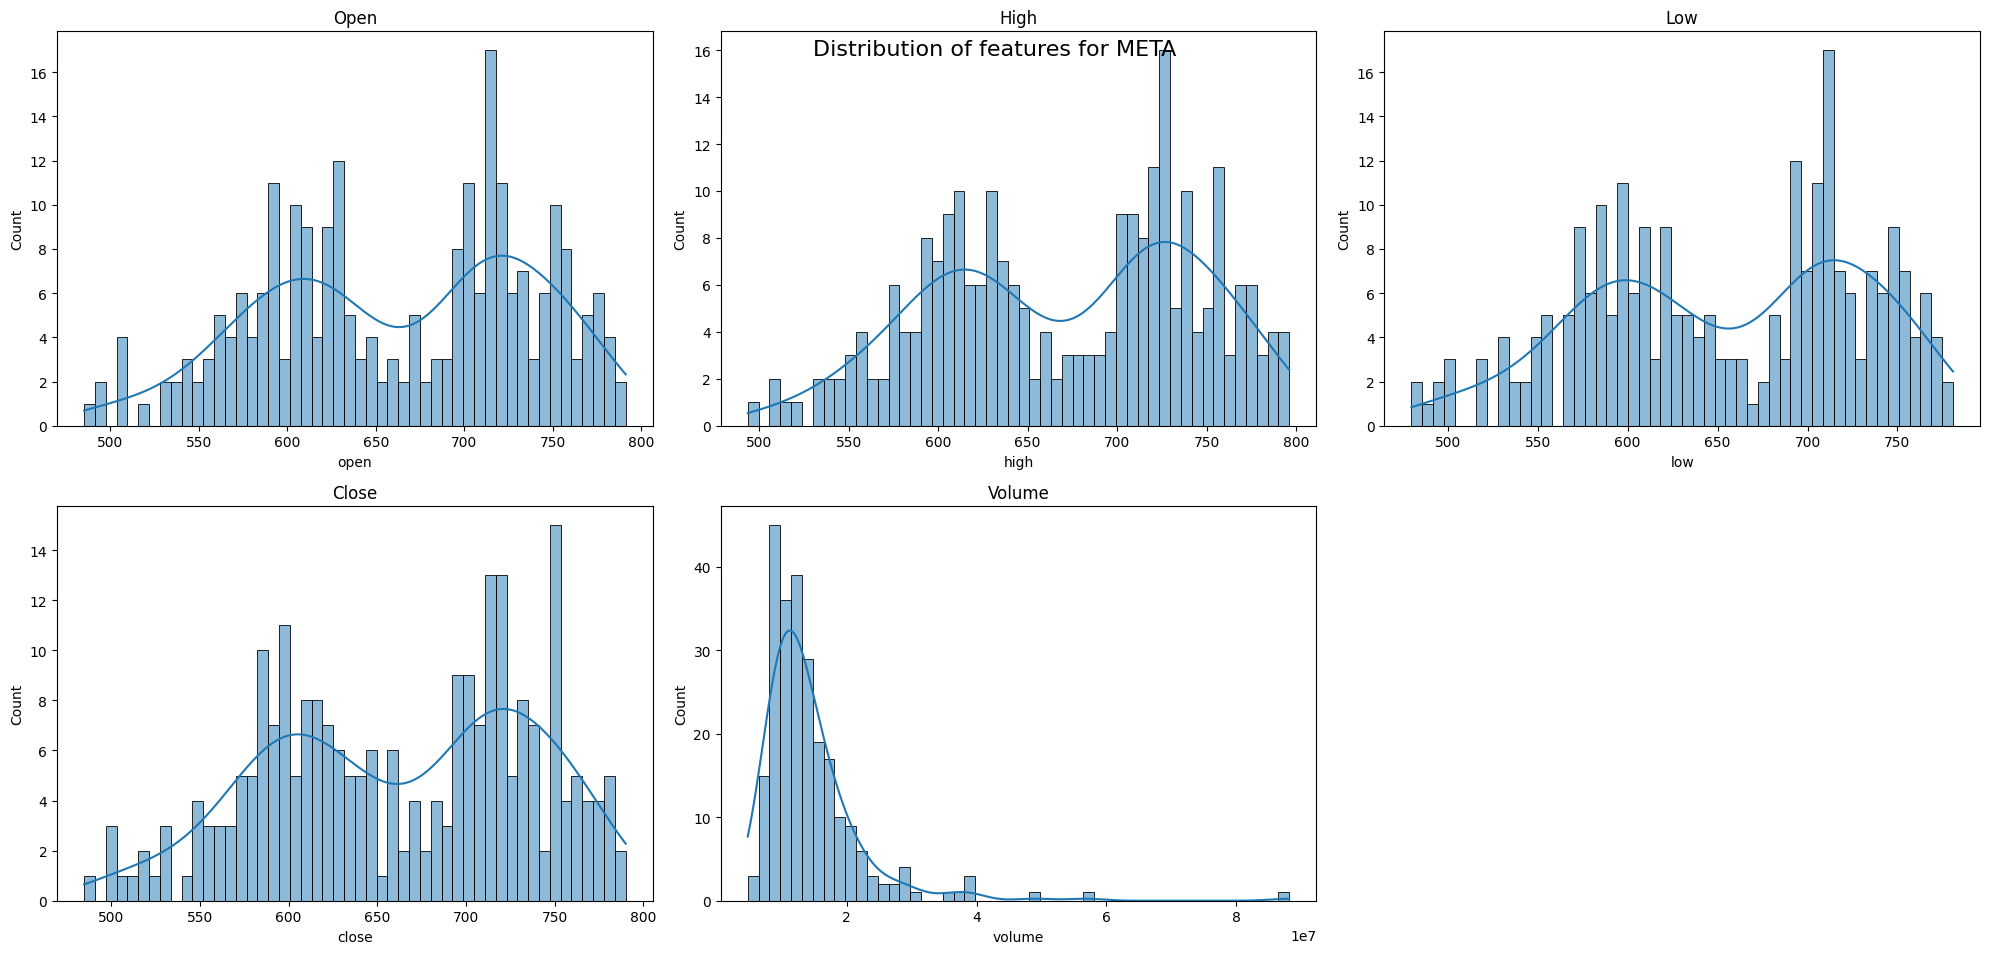

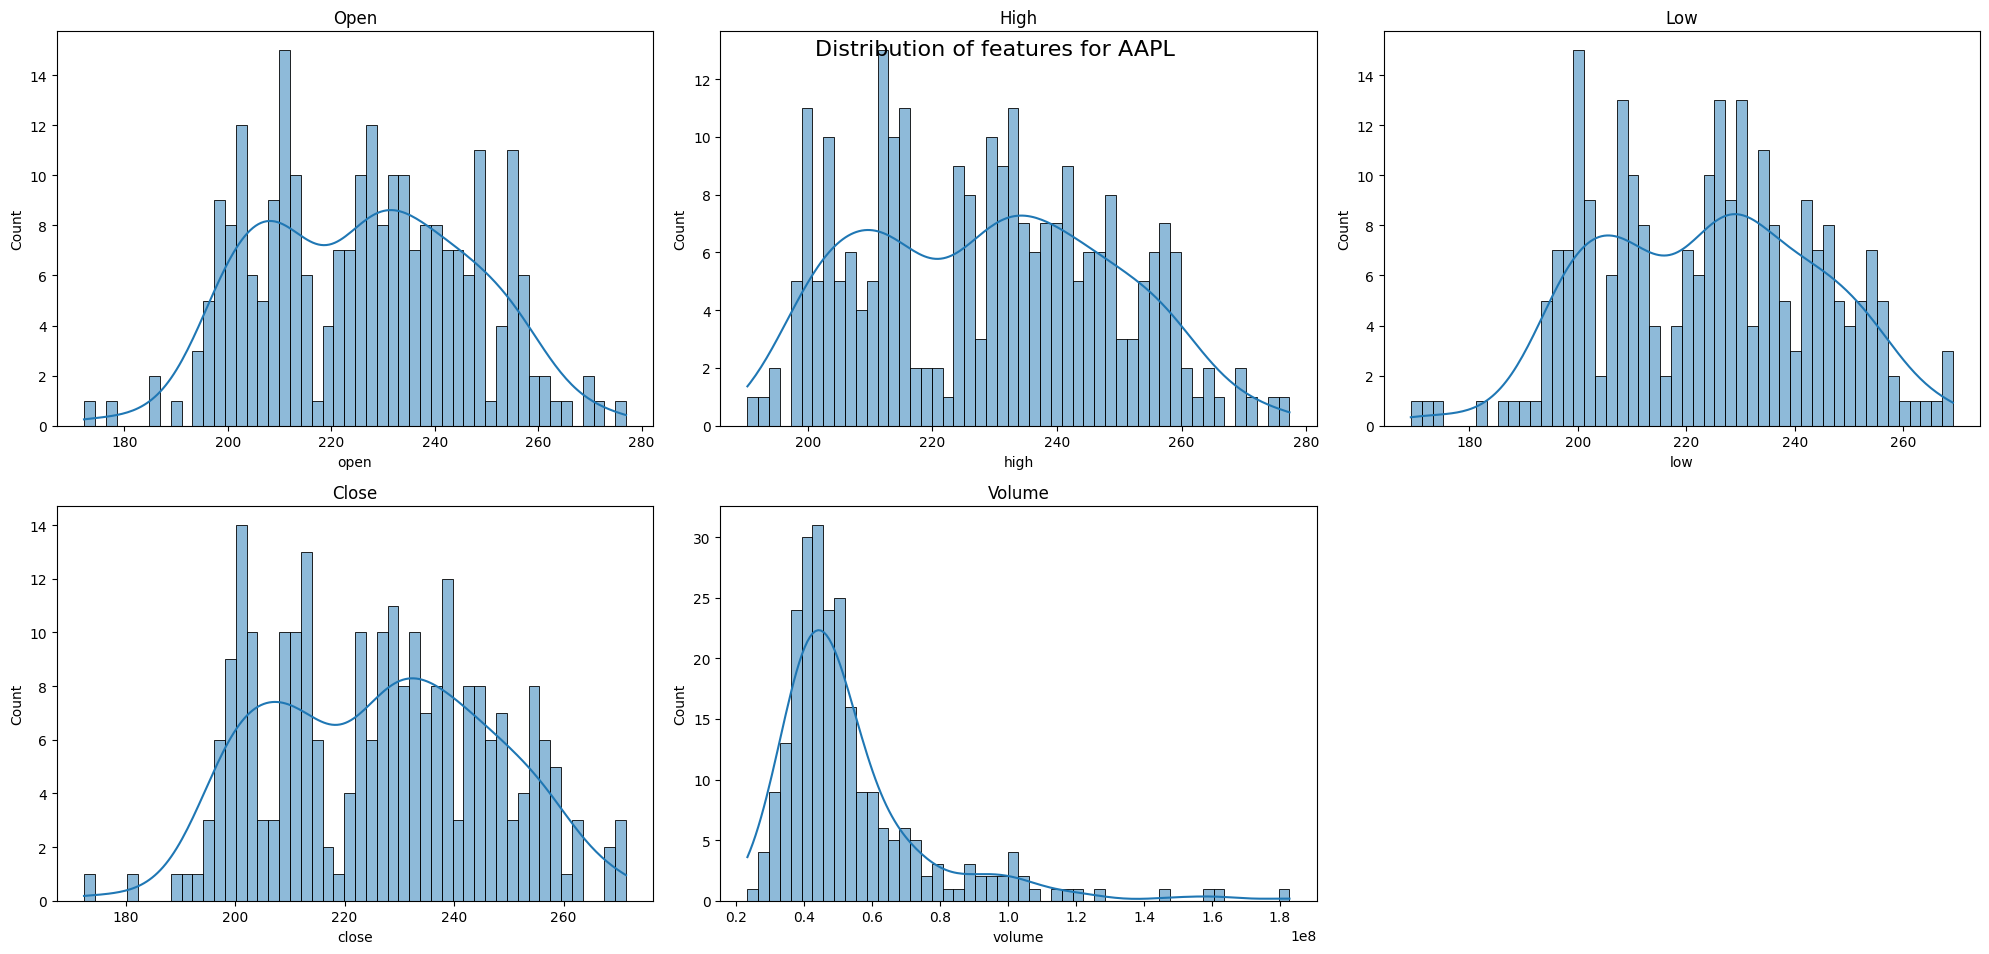

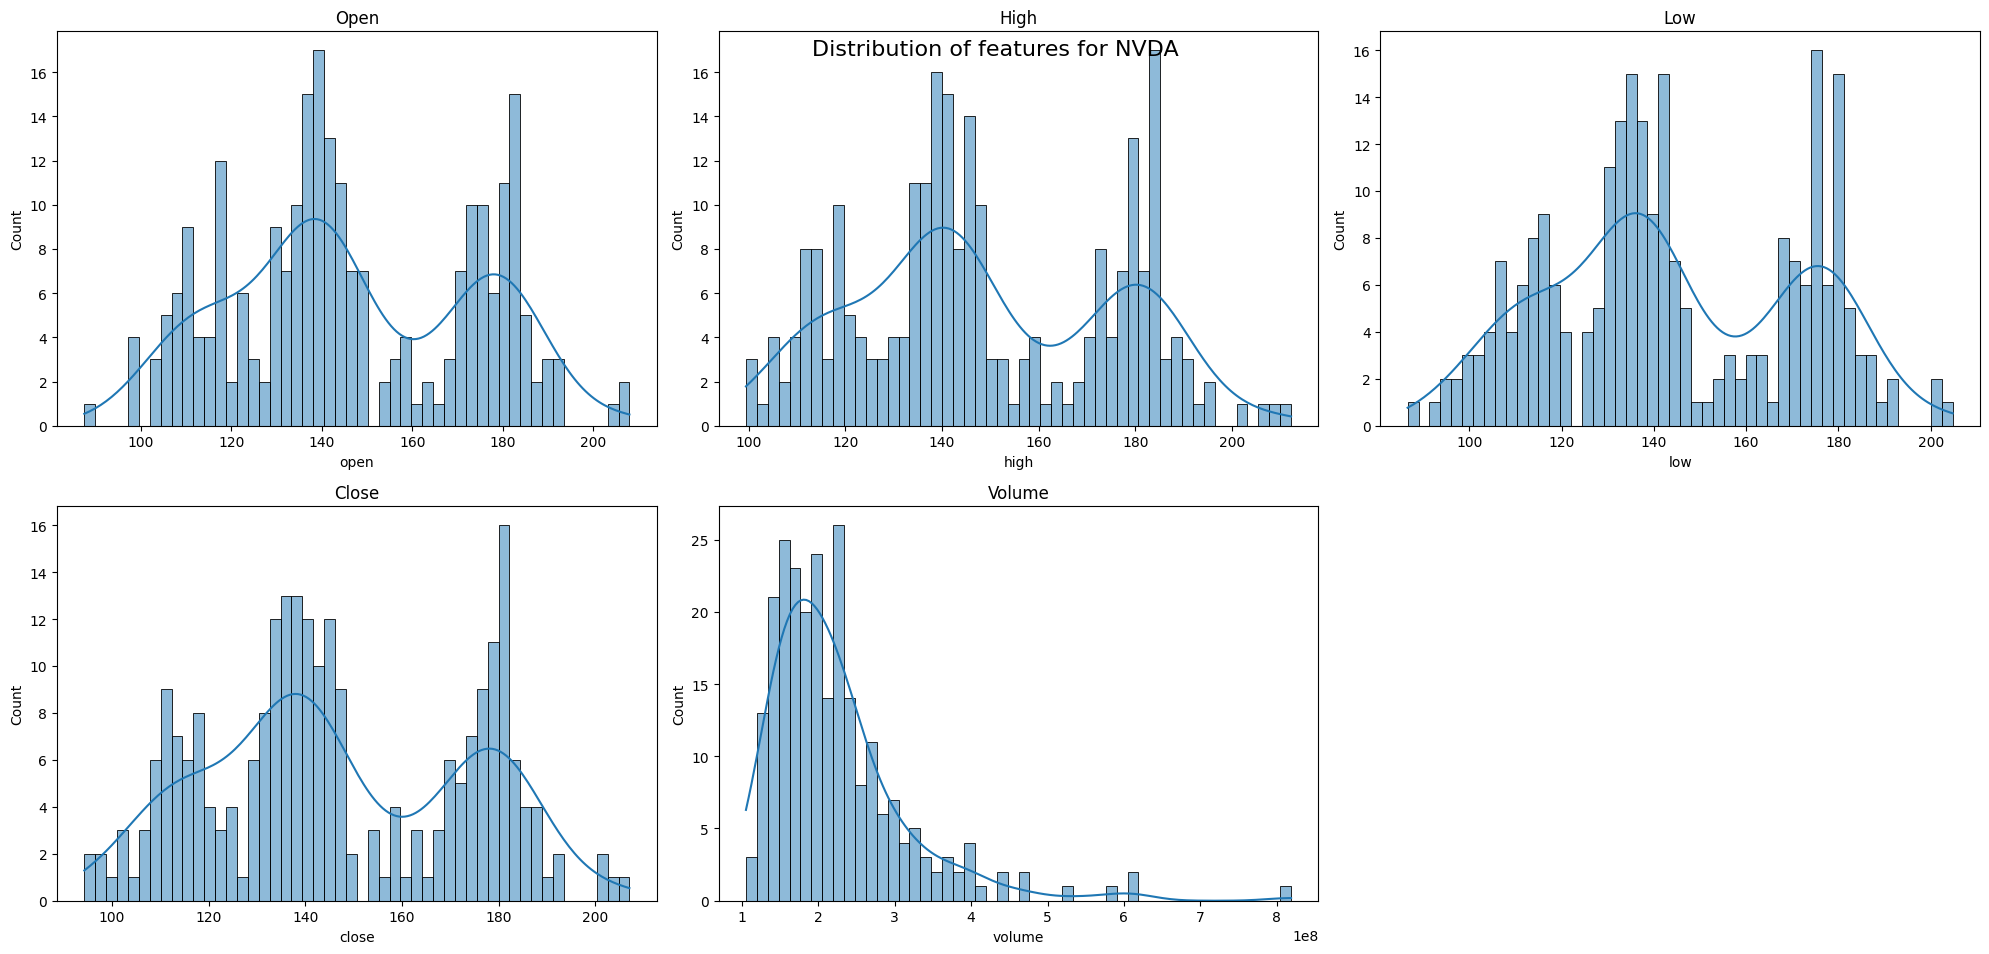

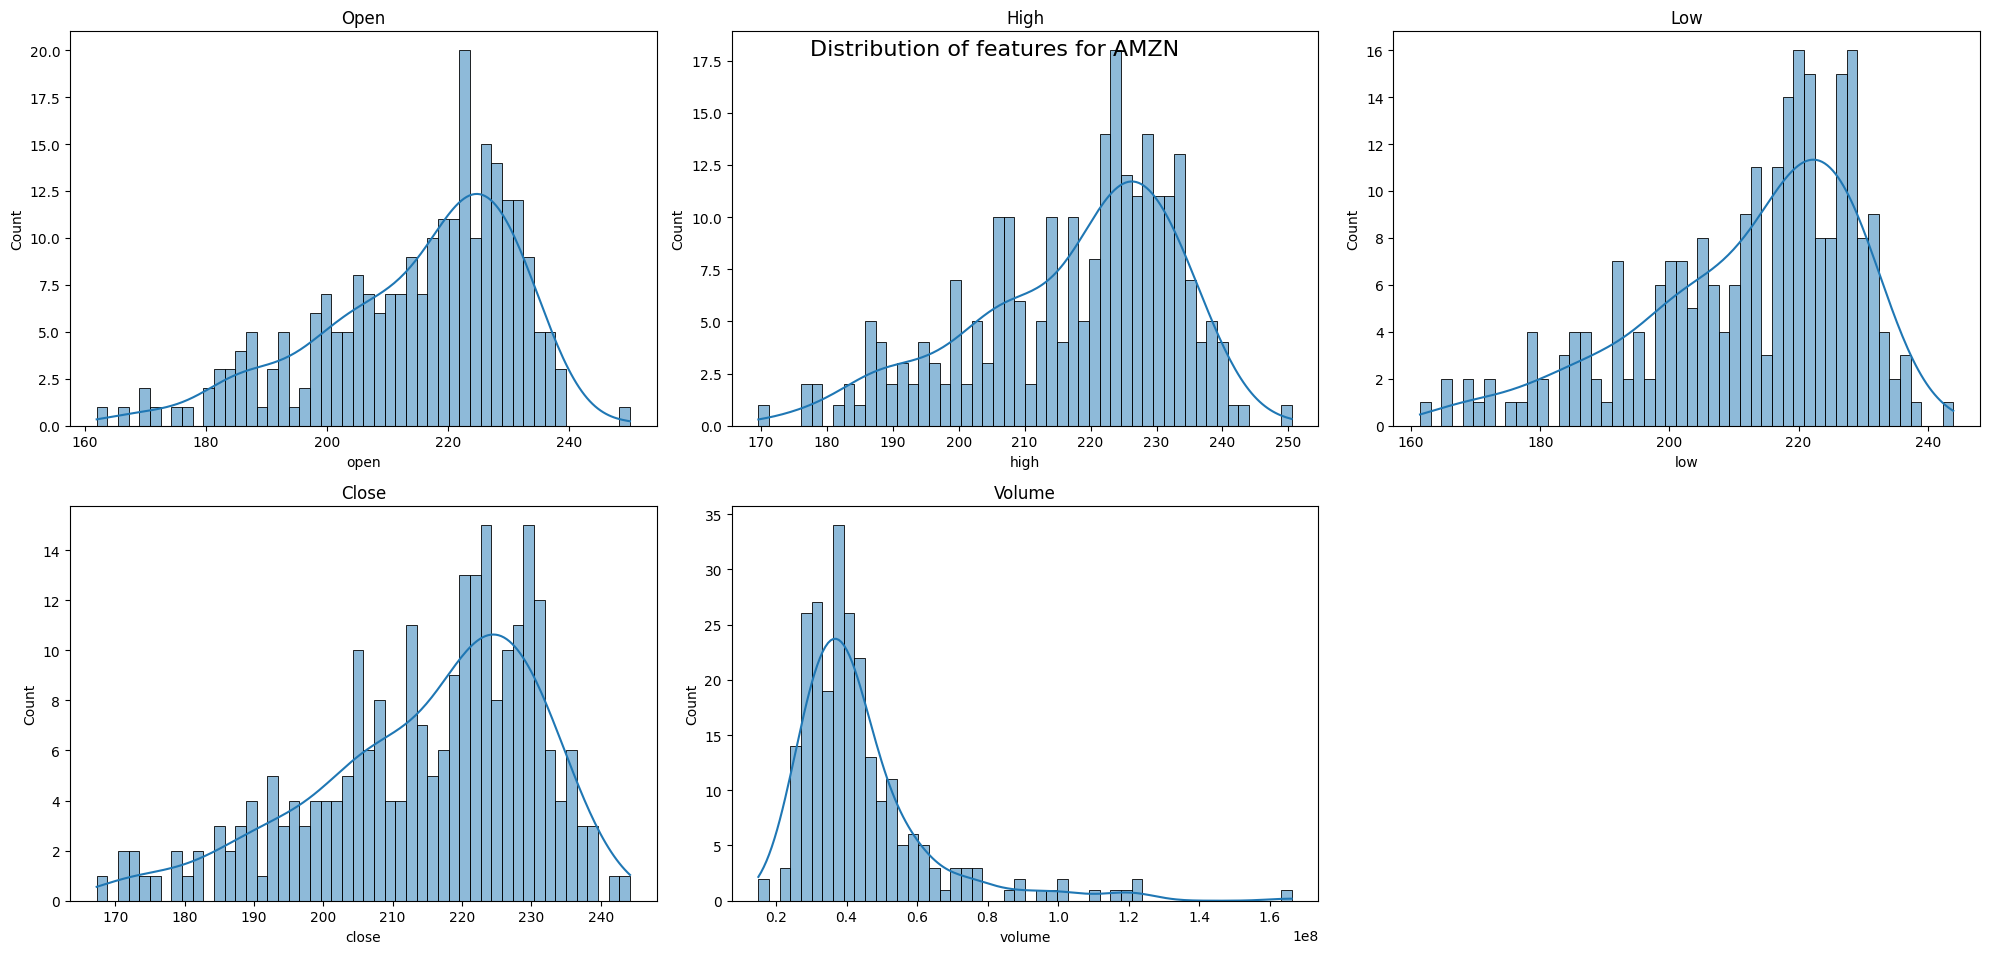

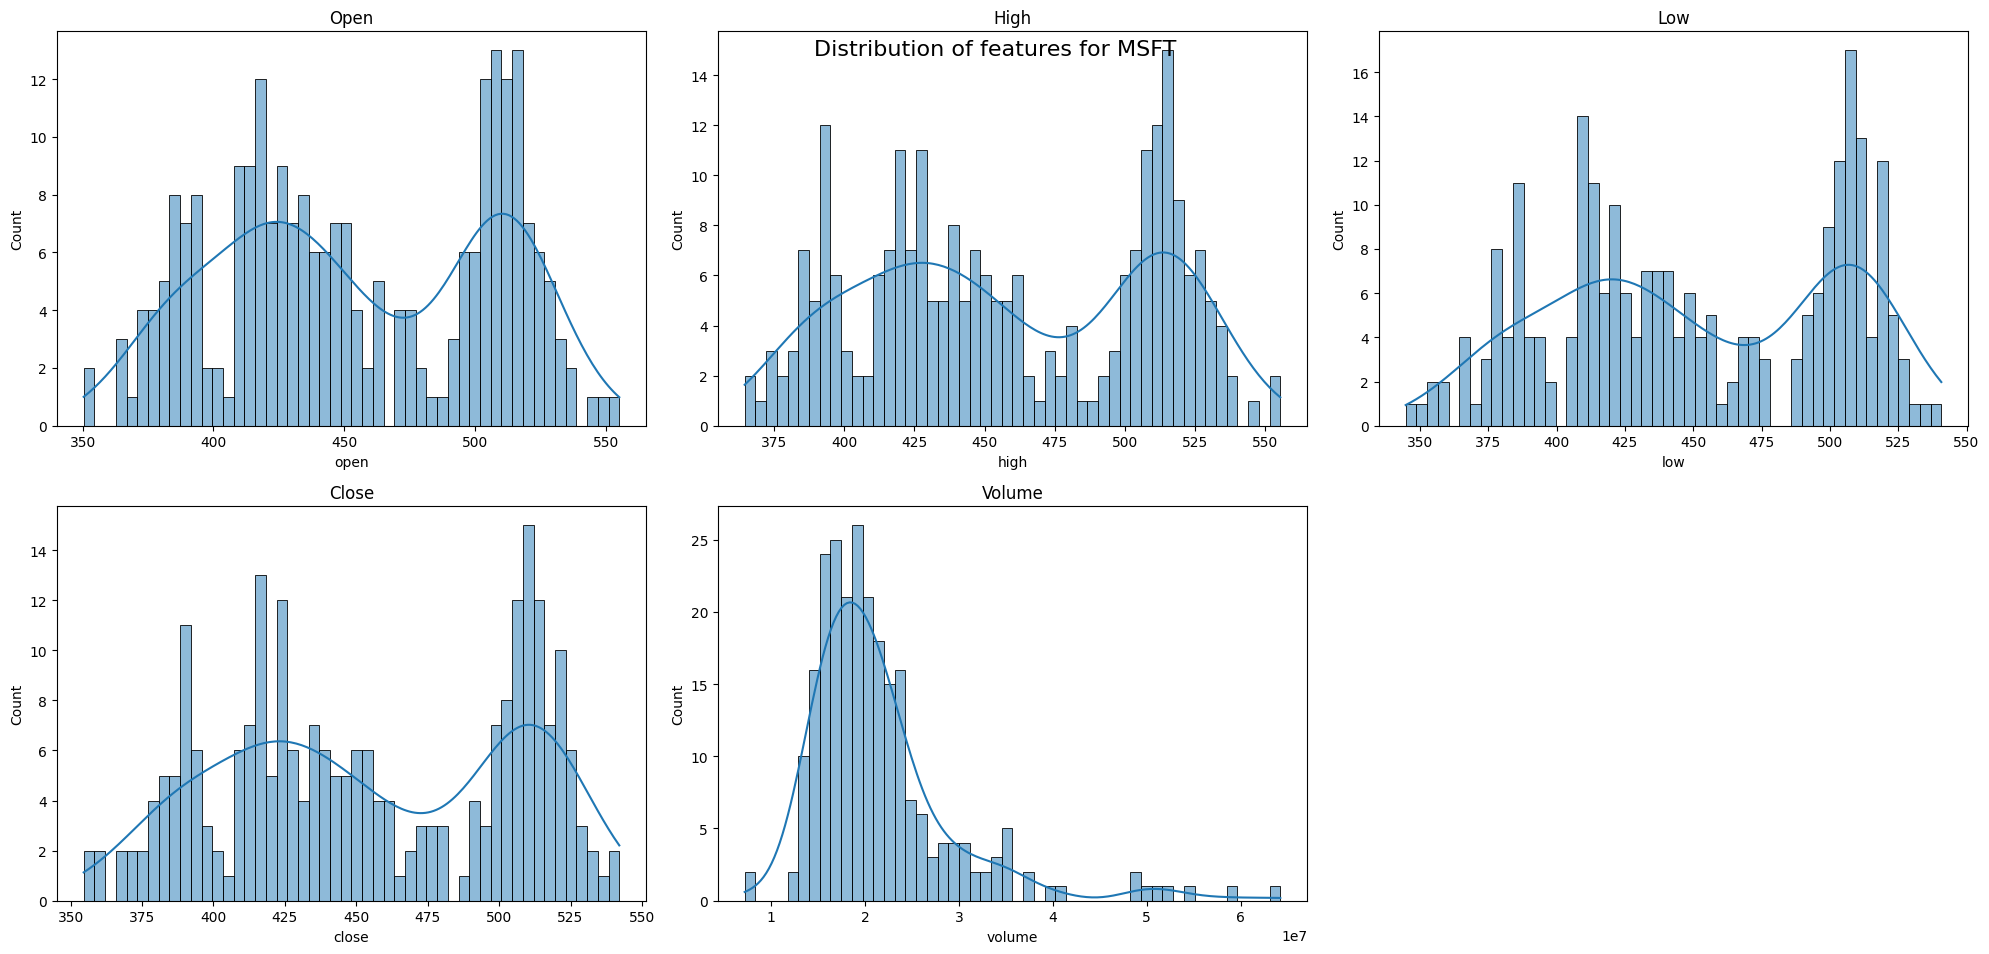

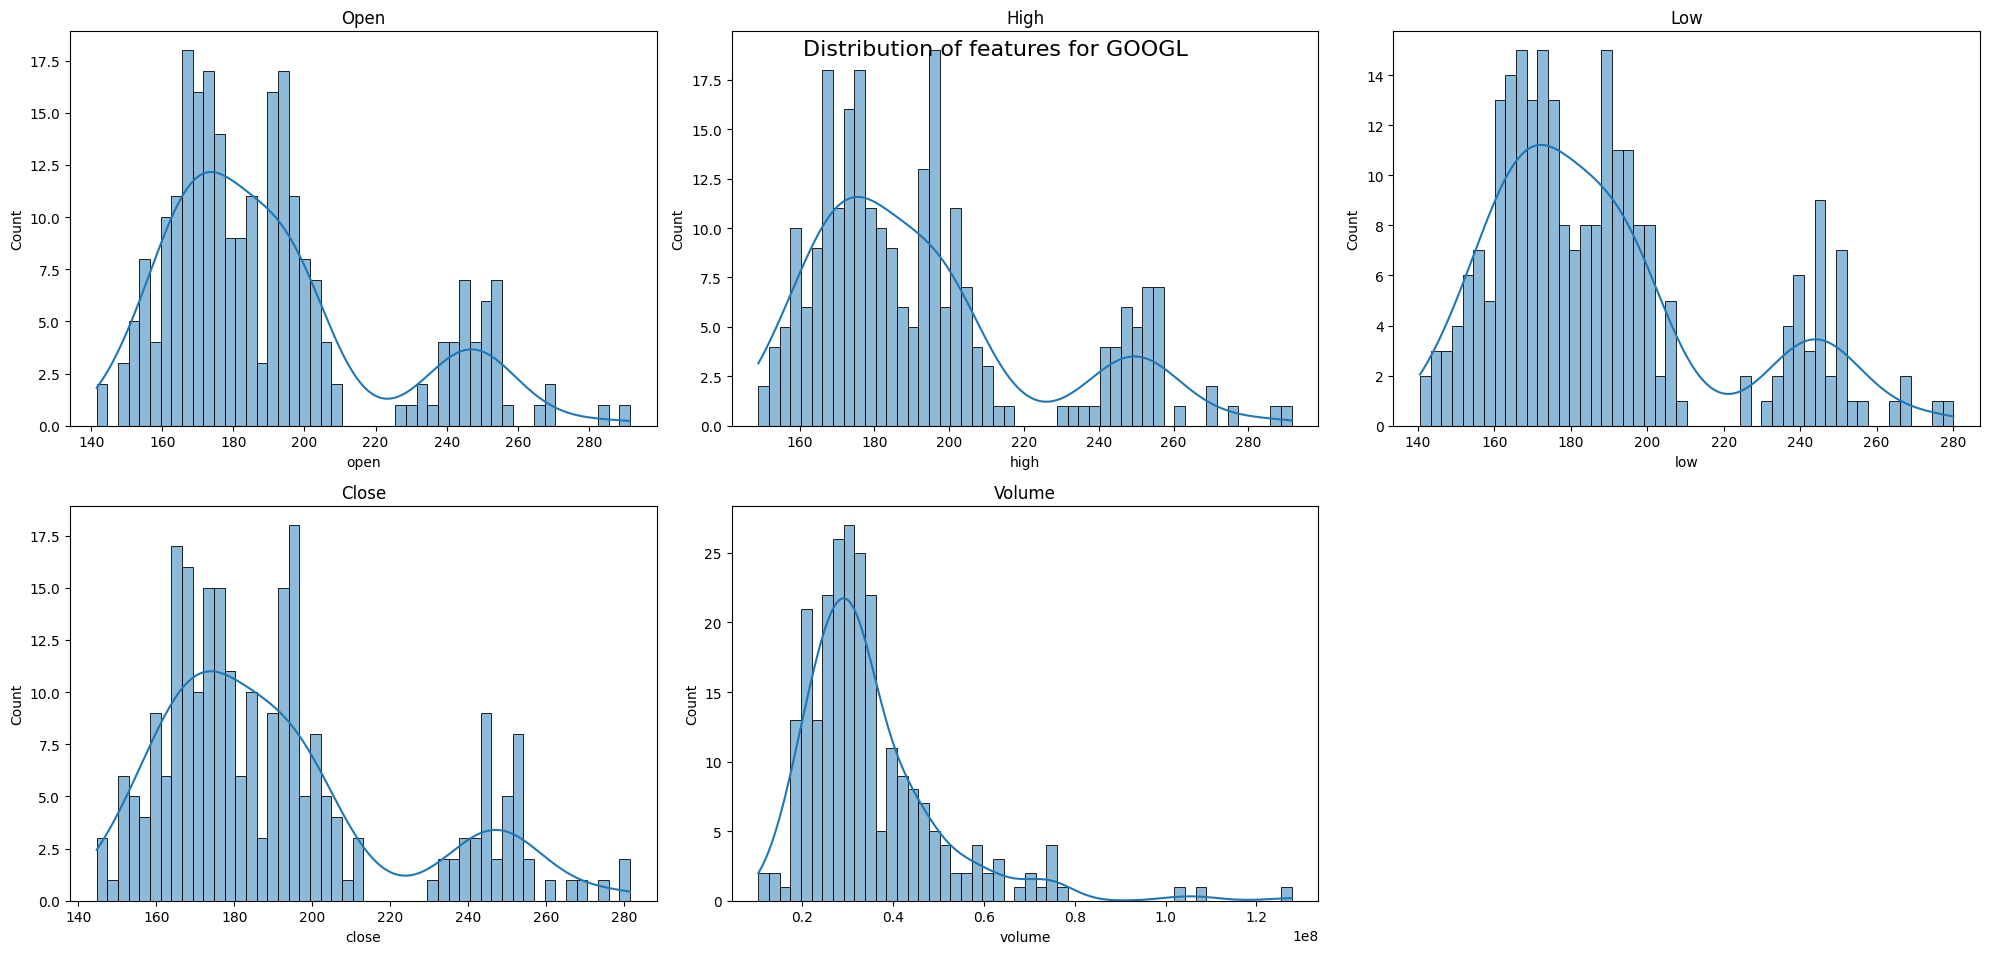

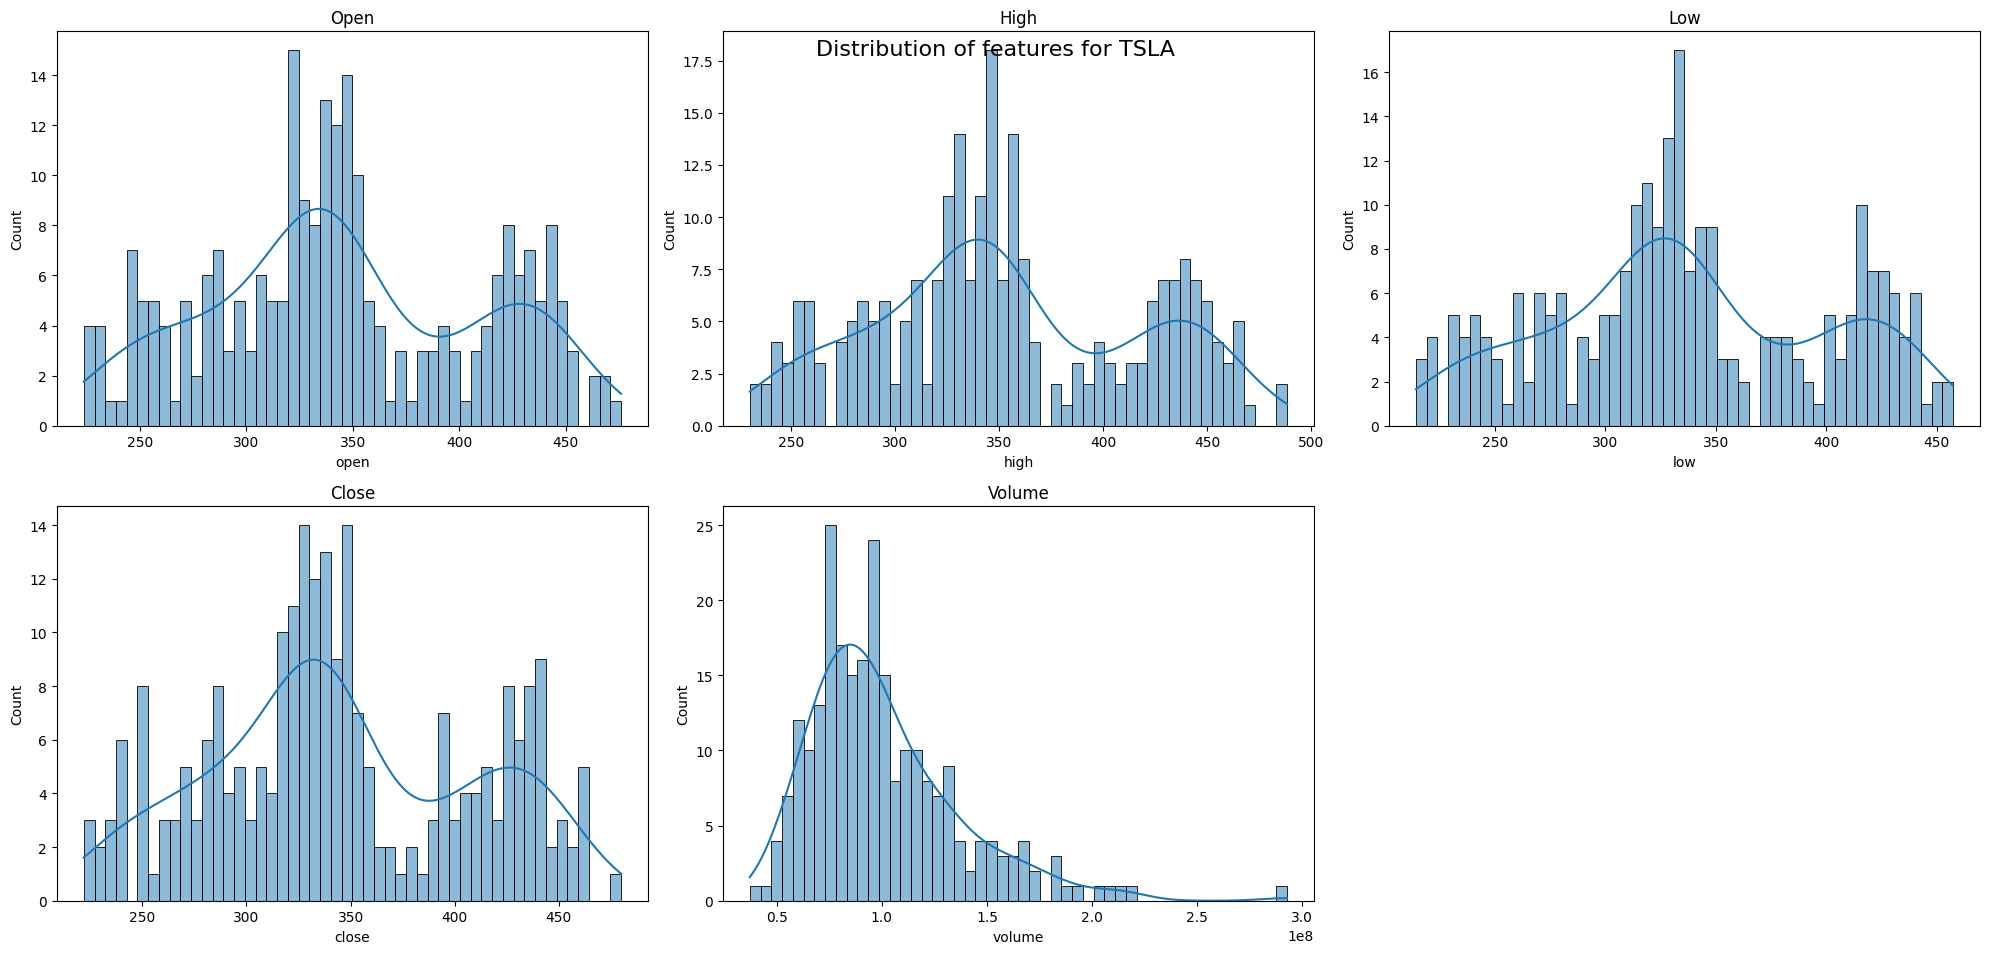

In [11]:
features = ["open", "high", "low", "close", "volume"]
tickers = df["symbol"].unique()

for ticker in tickers:
    subset = df[df["symbol"] == ticker]
    plt.figure(figsize=(20, 10))
    plt.suptitle(f"Distribution of features for {ticker}", fontsize=16, y=0.92)

    for i, col in enumerate(features):
        plt.subplot(2, 3, i + 1)
        sns.histplot(subset[col], kde=True, bins=50)
        plt.title(col.capitalize())
    plt.tight_layout()
    plt.show()

>
**Price distribution (Open, High, Low, Close)**

* Except for Amazon, whose all prices distribution are left-skewed, the rest don't have a near perfect normal bell curve but a multi-modal pattern.

**Volume distribution**

* Heavily right-skewed across all tickers. --> Possible further investigation to detect any outlier.

## Outliers

In [12]:
features = ["open", "high", "low", "close", "volume"]

for col in features:
    df[f"{col}_outlier"] = df.groupby("symbol", group_keys=False).apply(
        lambda g: detect_iqr_outliers(g, col)
    )

outliers = df[
    (df["open_outlier"]) |
    (df["high_outlier"]) |
    (df["low_outlier"]) |
    (df["close_outlier"]) |
    (df["volume_outlier"])
]

print(f"Total outliers detected: {len(outliers)}")
outliers.head()


Total outliers detected: 151


,date,symbol,open,high,low,close,volume,adj_close,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier
32,2024-12-20,META,590.58,603.11,580.0,585.25,48917700.0,585.25,False,False,False,False,True
54,2025-01-27,META,626.61,663.87,625.1,659.88,28354400.0,659.88,False,False,False,False,True
57,2025-01-30,META,696.82,710.79,676.1,687.00,29322900.0,687.00,False,False,False,False,True
101,2025-04-03,META,546.22,552.56,530.3,531.62,34777500.0,531.62,False,False,False,False,True
102,2025-04-04,META,506.62,518.00,494.2,504.73,38515100.0,504.73,False,False,False,False,True


>
Upon research, **outliers in stock market data are often normal** and represent real market events (e.g., earnings announcements, stock splits, or sudden macroeconomic changes).

**Plan:**  Evaluate both versions of the dataset — with and without scaling — to assess model performance sensitivity to outlier handling.


## Relationship

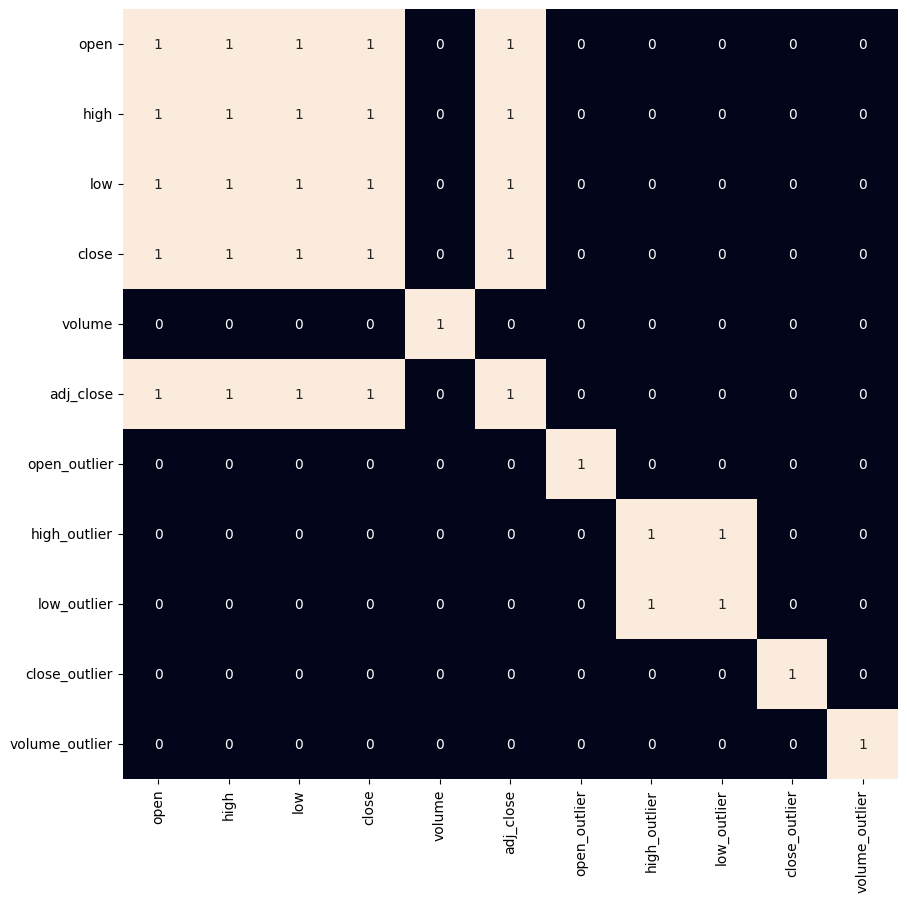

In [13]:
plt.figure(figsize=(10, 10)) 

sns.heatmap(df.drop(['date', 'symbol'], axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

> 
* The **price-related features (`open`, `high`, `low`, `close`) are perfectly correlated** (r ≈ 1). → This indicates high redundancy — they move together as part of the same daily price structure.
* outlier columns are exempted since they serve different purposes.

--> One price column (e.g., `close`) may be sufficient to represent price level.


## Time-series analysis

In [14]:
# Ensure date is a pandas datetime (not python date/object)
df["date"] = pd.to_datetime(df["date"], errors="raise")

# Create separate integer columns
df["day"] = df["date"].dt.day
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

df.head()

,date,symbol,open,high,low,close,volume,adj_close,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier,day,month,year
0,2024-11-05,META,567.30,573.48,566.67,572.43,9748300.0,572.43,False,False,False,False,False,5,11,2024
1,2024-11-06,META,562.75,573.00,555.17,572.05,18305400.0,572.05,False,False,False,False,False,6,11,2024
2,2024-11-07,META,576.89,594.80,575.21,591.70,14653700.0,591.70,False,False,False,False,False,7,11,2024
3,2024-11-08,META,591.54,593.10,584.52,589.34,9403300.0,589.34,False,False,False,False,False,8,11,2024
4,2024-11-11,META,586.36,587.00,576.51,583.17,10209100.0,583.17,False,False,False,False,False,11,11,2024


In [15]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,date,symbol,open,high,low,close,volume,adj_close,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier,day,month,year,is_quarter_end
0,2024-11-05,META,567.30,573.48,566.67,572.43,9748300.0,572.43,False,False,False,False,False,5,11,2024,0
1,2024-11-06,META,562.75,573.00,555.17,572.05,18305400.0,572.05,False,False,False,False,False,6,11,2024,0
2,2024-11-07,META,576.89,594.80,575.21,591.70,14653700.0,591.70,False,False,False,False,False,7,11,2024,0
3,2024-11-08,META,591.54,593.10,584.52,589.34,9403300.0,589.34,False,False,False,False,False,8,11,2024,0
4,2024-11-11,META,586.36,587.00,576.51,583.17,10209100.0,583.17,False,False,False,False,False,11,11,2024,0


In [16]:
df.groupby("is_quarter_end").mean(numeric_only=True)

,open,high,low,close,volume,adj_close,open_outlier,high_outlier,low_outlier,close_outlier,volume_outlier,day,month,year
is_quarter_end,,,,,,,,,,,,,,
0,319.487692,323.770797,315.023954,319.613273,7.063507e+07,319.610459,0.016450,0.013853,0.016450,0.015584,0.079654,16.084848,6.042424,2024.890909
1,321.444701,325.559226,316.957929,321.353029,7.035474e+07,321.351928,0.015491,0.017212,0.015491,0.012048,0.051635,15.614458,7.518072,2024.746988


> Trade price is indeed higher during quarter end. Trade volume decrease.

## Target

In [17]:
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)

df["target"] = (df.groupby("symbol")["close"].shift(-1) > df["close"]).astype(int)

In [18]:
# Sanity check
for sym in df["symbol"].unique():
    check = df.loc[df["symbol"] == sym, ["date","close","target"]].head(5)
    print(f"\n{sym}")
    print(check)


AAPL
        date   close  target
0 2024-11-05  223.45       0
1 2024-11-06  222.72       1
2 2024-11-07  227.48       0
3 2024-11-08  226.96       0
4 2024-11-11  224.23       0

AMZN
          date   close  target
248 2024-11-05  199.50       1
249 2024-11-06  207.09       1
250 2024-11-07  210.05       0
251 2024-11-08  208.18       0
252 2024-11-11  206.84       1

GOOGL
          date   close  target
496 2024-11-05  169.74       1
497 2024-11-06  176.51       1
498 2024-11-07  180.75       0
499 2024-11-08  178.35       1
500 2024-11-11  180.35       1

META
          date   close  target
744 2024-11-05  572.43       0
745 2024-11-06  572.05       1
746 2024-11-07  591.70       0
747 2024-11-08  589.34       0
748 2024-11-11  583.17       1

MSFT
          date   close  target
992 2024-11-05  411.46       1
993 2024-11-06  420.18       1
994 2024-11-07  425.43       0
995 2024-11-08  422.54       0
996 2024-11-11  418.01       1

NVDA
           date   close  target
1240 2024-11-

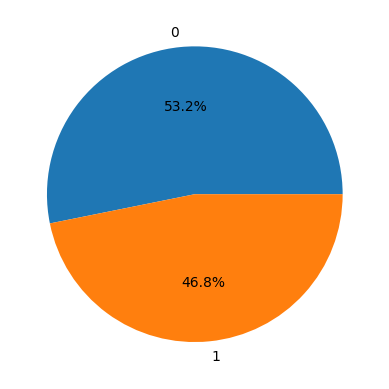

In [19]:
plt.pie(df['target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

> Roughly 50-50 ratio for the target, no imbalance problem in this case.

# Reference

* [Stock Price Prediction using Machine Learning in Python](https://www.geeksforgeeks.org/machine-learning/stock-price-prediction-using-machine-learning-in-python/)